# Importamos y Cogemos Material Necesario

Declaramos las librerias a usar

We Declare the libraries to use 

In [100]:
import os
import zipfile
import tensorflow as tf
import keras
import gdown
import zipfile
import tensorflow as tf
import keras_preprocessing
import matplotlib.pyplot as plt
import pandas as pd

from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import Model
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator

Descargamos nuestro dataset de google drive a nuestra carpeta temporal:  "/tmp/vehdata"

Download our dataset from google drive and store it on our local machine on the address: "/tmp/vehdata"

In [101]:



url = 'https://drive.google.com/uc?id=1GWjZDtSnsCHLb-NqaMlvliM87DdciYtJ'
output = '/tmp/vehdata.zip'
gdown.download(url, output, quiet=False)





Downloading...
From: https://drive.google.com/uc?id=1GWjZDtSnsCHLb-NqaMlvliM87DdciYtJ
To: /tmp/vehdata.zip
100%|██████████| 1.30G/1.30G [00:47<00:00, 27.5MB/s]


'/tmp/vehdata.zip'

Creamos los directorios de nuestro conjunto de datos 

Specify our training and validation folders 

In [102]:


local_zip = '/tmp/vehdata.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

base_dir = '/tmp/vehdata'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directorio para las imagenes de entrenamiento SIN infantes
# Directory with our training pictures WITH NO infants 
train_empty_dir = os.path.join(train_dir, 'empty')

# Directorio para las imagenes de entrenamiento CON infantes
# Directory with our training WITH infants in the car
train_infant_dir = os.path.join(train_dir, 'infant')

# Directorio para las imagenes de validacion SIN infantes
# Directory with our validation WITH NO infants
validation_empty_dir = os.path.join(validation_dir, 'empty')

# Directorio para las imagenes de validacion CON infantes
# Directory with our validation WITH infants in the car
validation_infant_dir = os.path.join(validation_dir, 'infant')

Utilizamos tecnicas de aumento de datos, para crear mas imagenes de entrenamiento y mejorar nuestra red convolucional

We use data aumentation to increase the size of our training data set, which would improve our convolutional neural network

In [103]:



TRAINING_DIR = "/tmp/vehdata/train/"
train_datagen = ImageDataGenerator(
      rescale = 1./255,
	    rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

VALIDATION_DIR = "/tmp/vehdata/validation/"
validation_datagen = ImageDataGenerator(rescale = 1./255)

# Imagenes de entrenamiento en grupos de 20 usando el generador train_datagen 
# Training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 20,
                                                    class_mode = 'binary', 
                                                    target_size = (150, 150))     

# Imagenes de validacion en grupos de 20 usando el generador validation_datagen 
# Validation images in batches of 20 using validation_datagen generator
validation_generator =  validation_datagen.flow_from_directory( validation_dir,
                                                          batch_size  = 20,
                                                          class_mode  = 'binary', 
                                                          target_size = (150, 150))

Found 1000 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


Creamos el modelo de la red neuronal con 4 capaz convolucionales y una capa oculta.

Define a CNN model with 4 convolutional layers and 1 hiden layer. 

In [104]:
model = tf.keras.models.Sequential([
    # Primera convolucion
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # Segunda convolucion
    # The second convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Tercera convolucion
    # The third convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Cuarta convolucion
    # The fourth convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # capa flatten 
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    #capa oculta con 512 neuronas
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')



])


Creamos a "callback" para parar el entrenamiento de nuestra red neuronal cuando alcanzemos un determinado valor de precision. 

Declare a callback so we can stop training whenever we hit 95% of accuracy in our training data

In [105]:

class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.95):
      print("\nReached 95% accuracy so cancelling training!")
      self.model.stop_training = True

Empezamos el entrenamiento de nuestra red neuronal 

Compile our CNN to start training 

In [106]:
#opt = keras.optimizers.RMSprop(learning_rate=0.0001)
model.compile(loss = 'binary_crossentropy', optimizer="RMSprop", metrics=['accuracy'])

callbacks = myCallback()
history = model.fit(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 50,
            epochs = 100,
            validation_steps = 2,
            verbose = 2,
            callbacks=[callbacks])
model.save("rps1.h5")

Epoch 1/100


2022-11-06 14:25:01.185220: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-06 14:25:28.068228: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


50/50 - 29s - loss: 0.7293 - accuracy: 0.4970 - val_loss: 0.6729 - val_accuracy: 0.6500 - 29s/epoch - 573ms/step
Epoch 2/100
50/50 - 28s - loss: 0.6936 - accuracy: 0.5550 - val_loss: 0.6765 - val_accuracy: 0.6000 - 28s/epoch - 556ms/step
Epoch 3/100
50/50 - 27s - loss: 0.6928 - accuracy: 0.5480 - val_loss: 0.6430 - val_accuracy: 0.7000 - 27s/epoch - 548ms/step
Epoch 4/100
50/50 - 29s - loss: 0.6822 - accuracy: 0.5820 - val_loss: 0.6777 - val_accuracy: 0.5250 - 29s/epoch - 572ms/step
Epoch 5/100
50/50 - 28s - loss: 0.6724 - accuracy: 0.6050 - val_loss: 0.6803 - val_accuracy: 0.6250 - 28s/epoch - 565ms/step
Epoch 6/100
50/50 - 28s - loss: 0.6485 - accuracy: 0.6410 - val_loss: 0.5058 - val_accuracy: 0.7750 - 28s/epoch - 561ms/step
Epoch 7/100
50/50 - 29s - loss: 0.6173 - accuracy: 0.6730 - val_loss: 0.4798 - val_accuracy: 0.8500 - 29s/epoch - 577ms/step
Epoch 8/100
50/50 - 28s - loss: 0.5962 - accuracy: 0.6960 - val_loss: 0.4375 - val_accuracy: 0.8250 - 28s/epoch - 569ms/step
Epoch 9/100


Graficamos el entrenamiento de nuestra red neuronal, donde comparamos perdida, precision, perdida de entrenamiento y precision de entrenamiento durante las epocas que proceso. 

We plot the training process to have a visual comparison between loss, accuracy, val_loss & val_accuracy and their changes over the multiple epochs 

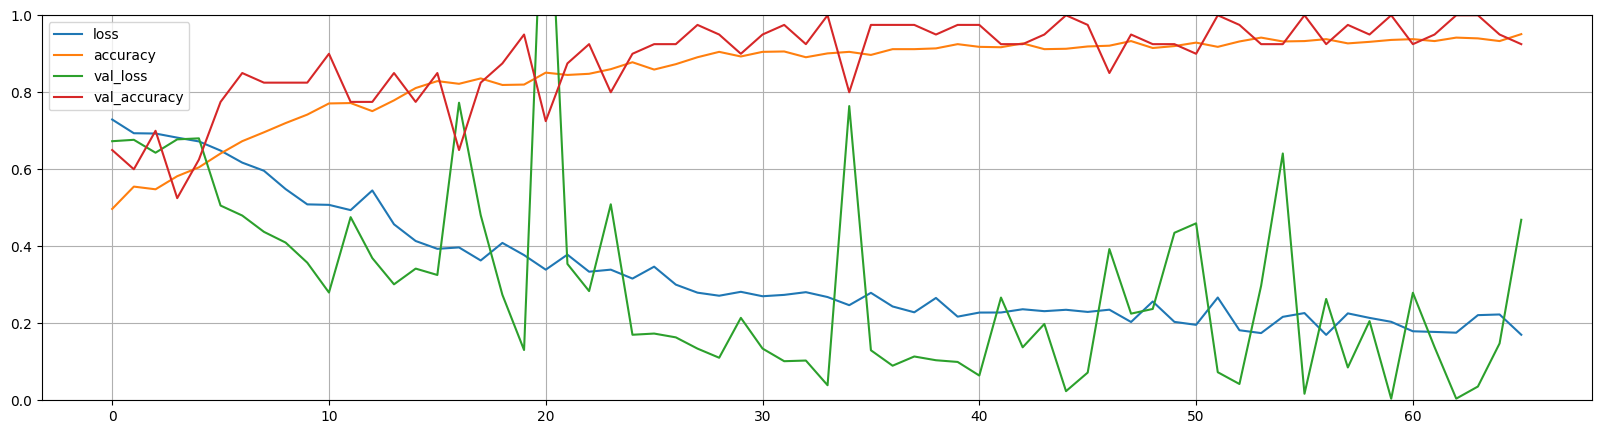

In [107]:


pd.DataFrame(history.history).plot(figsize=(20,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

Tomamos nuestro pequeño conjunto de datos de imagenes que usaremos para evaluar el modelo  (NOTA: para esta entrega solo estamos re usando el conjunto de test, se proporcionara un conjunto de datos nuevos con imagenes reales para evaluar su funcionalidad con imagenes reales y no un conjunto de datos hechos por computadora)

Declare our data set for predictions and execute our model 

In [108]:
va_datagen = ImageDataGenerator(rescale = 1./255)
val_real = va_datagen.flow_from_directory( validation_dir,
                                                          batch_size=200,
                                                          class_mode  = 'binary', 
                                                          target_size = (150, 150))
Xtest, ytest = next(val_real)
predictions = model.predict(Xtest)


Found 200 images belonging to 2 classes.
2/7 [=======>......................] - ETA: 0s

2022-11-06 14:56:14.096071: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 0s 32ms/step


Creamos una matriz de confusion para visualizar el desempeño por clase.

Display a confusion matrix to visualize our 2 labels and their performance. 

7/7 [==============================] - 0s 12ms/step


Text(113.9222222222222, 0.5, 'Actual label')

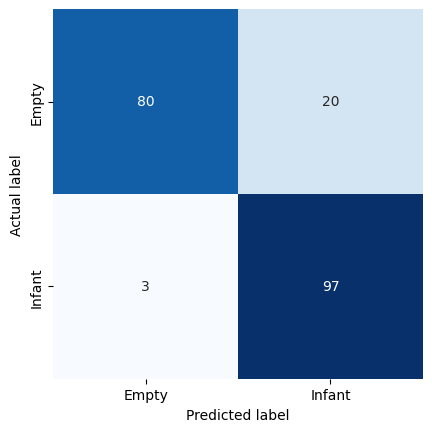

In [109]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
 
y_predicted = model.predict(Xtest) > 0.5
mat = confusion_matrix(ytest, y_predicted)
labels = val_real.class_indices.keys()
 
sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
            xticklabels=labels, yticklabels=labels)
 
plt.xlabel('Predicted label')
plt.ylabel('Actual label')

Mostramos precision recall y f1-score obtenido por nuestro modelo. 

Show key metrics of our model.

In [110]:
from sklearn.metrics import classification_report
print(classification_report(ytest, (y_predicted),target_names=val_real.class_indices.keys()))

              precision    recall  f1-score   support

       Empty       0.96      0.80      0.87       100
      Infant       0.83      0.97      0.89       100

    accuracy                           0.89       200
   macro avg       0.90      0.89      0.88       200
weighted avg       0.90      0.89      0.88       200

